In [1]:
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

from repviz.inference import run_inference
from repviz.models import FFN, FFN2, TinyTabularAttentionModel
from repviz.registry import Registry
from repviz.tools import cka, gram_linear
from repviz.plots import (
    activation_scatter,
    histogram,
    plot_cka,
    plot_query_attention_bar_seaborn,
    plot_binary_attention_seaborn,
)

In [2]:
data = np.load("test.npy")[:64]
label = np.load("test_y.npy")[:64] - 1
model = FFN(data.shape[1], 7)
model.load_state_dict(
    torch.load("../model/ffn_covtype_v1.pth", map_location=torch.device("cpu"))
)
model2 = FFN2(data.shape[1], 7)
model2.load_state_dict(
    torch.load("../model/ffn_covtype_v2.pth", map_location=torch.device("cpu"))
)
reg = Registry()
reg.register_model([model, model2])
results = run_inference(reg, data, label, "cpu", get_gradients=True)
print("Inference completed and outputs saved.")
x = torch.randn(20, 10)  # batch=20, seq_len=10
model_attn = TinyTabularAttentionModel(x.shape[1], 10)
reg_attn = Registry()
reg_attn.register_model([model_attn])
results_attn = run_inference(reg_attn, x, device="cpu", get_gradients=False)

Inference completed and outputs saved.


/Users/abnerteng/git/repviz/notebooks/../repviz/hooks.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(module.weight).detach().cpu()


In [13]:
results_attn["TinyTabularAttentionModel"]["model_info"]

{'input_proj': {'module_type': 'Linear',
  'args': (),
  'kwargs': {'in_features': 10, 'out_features': 320, 'bias': True}},
 'attn_block.norm': {'module_type': 'LayerNorm',
  'args': ((32,),),
  'kwargs': {'eps': 1e-05, 'elementwise_affine': True}},
 'attn_block.attn': {'module_type': 'AttentionScore',
  'args': (),
  'kwargs': {}},
 'attn_block.q_proj': {'module_type': 'Linear',
  'args': (),
  'kwargs': {'in_features': 32, 'out_features': 32, 'bias': False}},
 'attn_block.k_proj': {'module_type': 'Linear',
  'args': (),
  'kwargs': {'in_features': 32, 'out_features': 32, 'bias': False}},
 'attn_block.v_proj': {'module_type': 'Linear',
  'args': (),
  'kwargs': {'in_features': 32, 'out_features': 32, 'bias': False}},
 'attn_block.out_proj': {'module_type': 'Linear',
  'args': (),
  'kwargs': {'in_features': 32, 'out_features': 32, 'bias': True}},
 'classifier.0': {'module_type': 'Linear',
  'args': (),
  'kwargs': {'in_features': 32, 'out_features': 32, 'bias': True}},
 'classifier.1'

(0, 1)


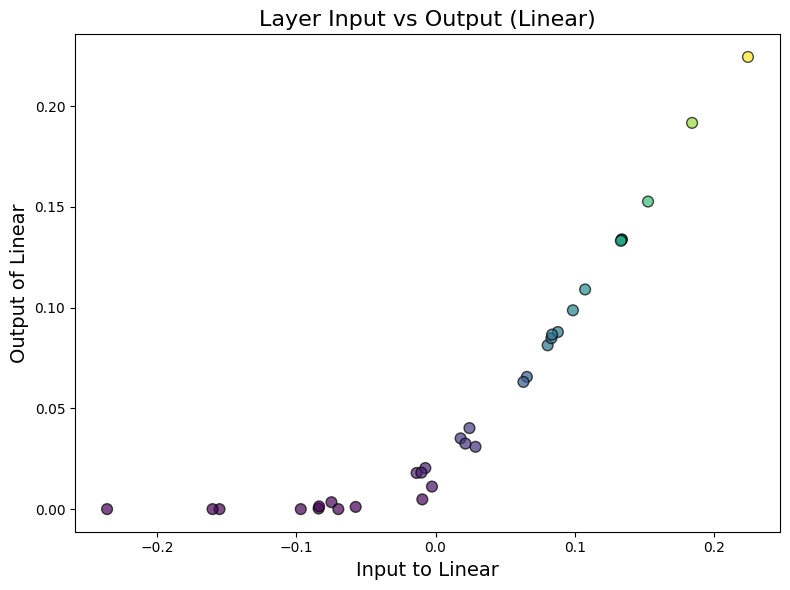

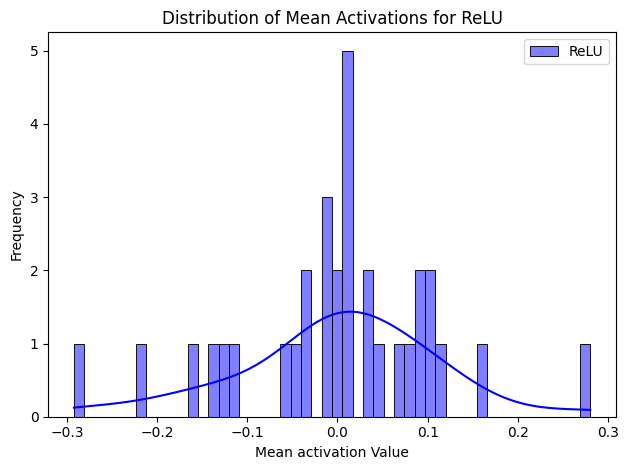

In [4]:
activation_scatter(
    results_attn["TinyTabularAttentionModel"]["activations"]["Linear:5"],
    results_attn["TinyTabularAttentionModel"]["activations"]["ReLU:0"],
    layer_name="Linear",
)
histogram(
    results_attn["TinyTabularAttentionModel"]["activations"]["LayerNorm:0"],
    viz_type="activation",
    layer_name="ReLU",
    bins=50,
)

[('Token 6', np.float32(0.226929)), ('Token 7', np.float32(0.11177927)), ('Token 3', np.float32(0.096747704)), ('Token 2', np.float32(0.08759594)), ('Token 9', np.float32(0.08344409)), ('Token 1', np.float32(0.0827602)), ('Token 5', np.float32(0.08141603)), ('Token 4', np.float32(0.07388354)), ('Token 8', np.float32(0.05490318))]


/Users/abnerteng/git/repviz/notebooks/../repviz/plots.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Attention Score", y="Token", data=df, palette="Blues_r")


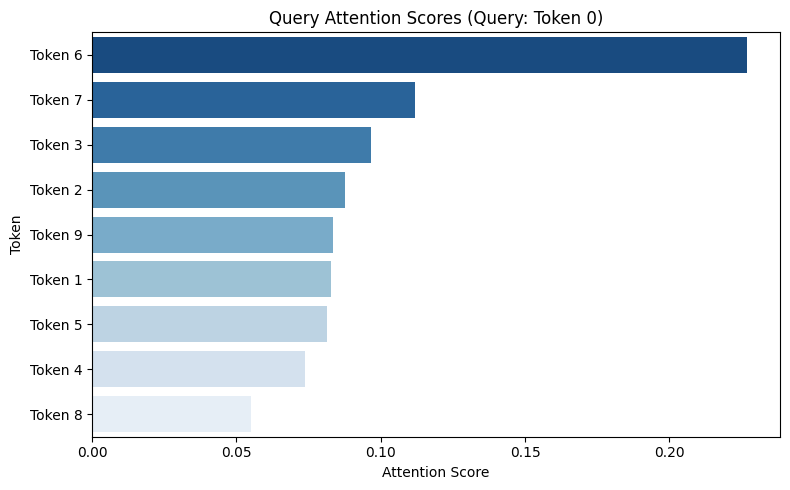

[('Token 6', np.float32(0.226929)),
 ('Token 7', np.float32(0.11177927)),
 ('Token 3', np.float32(0.096747704)),
 ('Token 2', np.float32(0.08759594)),
 ('Token 9', np.float32(0.08344409)),
 ('Token 1', np.float32(0.0827602)),
 ('Token 5', np.float32(0.08141603)),
 ('Token 4', np.float32(0.07388354)),
 ('Token 8', np.float32(0.05490318))]

In [5]:
plot_query_attention_bar_seaborn(
    results_attn["TinyTabularAttentionModel"]["activations"]["AttentionScore:0"][0][
        0, 0
    ],
    query_index=0,
    tokens=[
        f"Token {i}"
        for i in range(
            results_attn["TinyTabularAttentionModel"]["activations"][
                "AttentionScore:0"
            ][0][0, 0].shape[0]
        )
    ],
    title="Query Attention Scores",
)

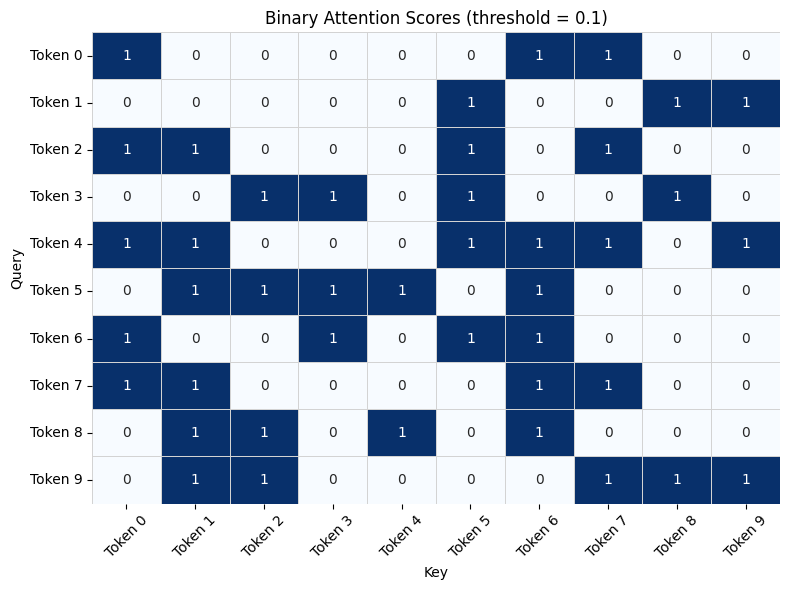

In [6]:
plot_binary_attention_seaborn(
    results_attn["TinyTabularAttentionModel"]["activations"]["AttentionScore:0"][0][
        0, 0
    ],
    threshold=0.1,
    tokens=[
        f"Token {i}"
        for i in range(
            results_attn["TinyTabularAttentionModel"]["activations"][
                "AttentionScore:0"
            ][0][0, 0].shape[0]
        )
    ],
    title="Binary Attention Scores",
)

(0, 1)


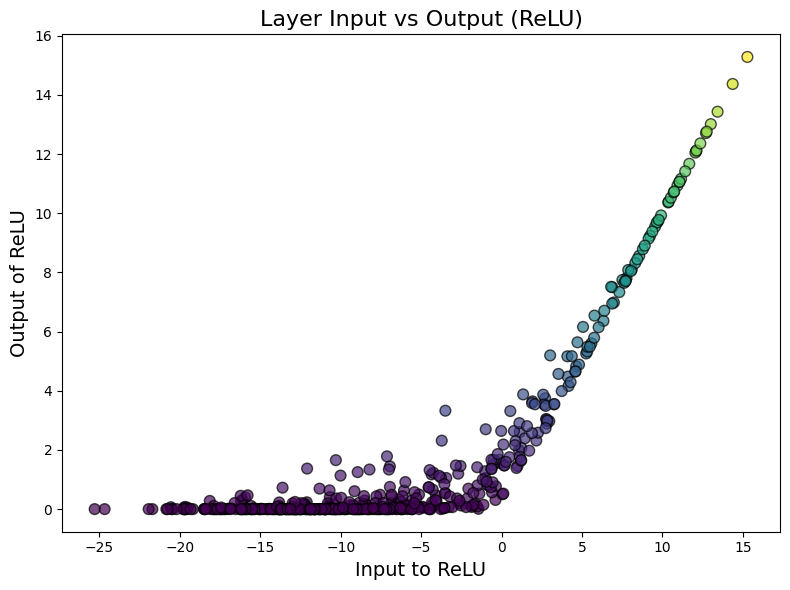

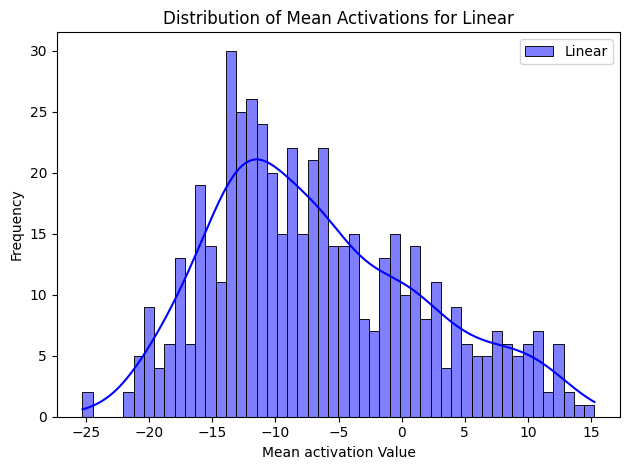

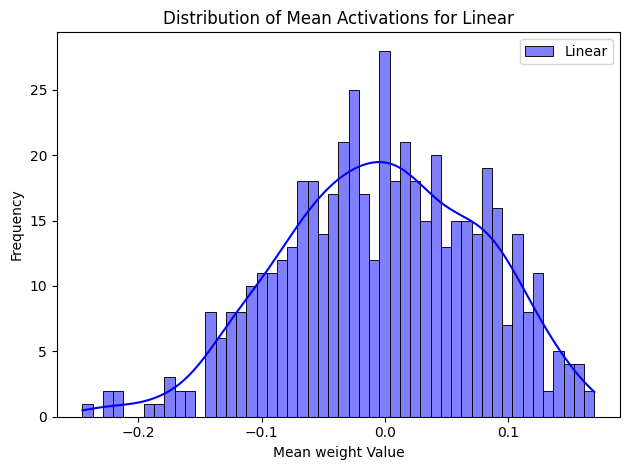

/Users/abnerteng/git/repviz/notebooks/../repviz/plots.py:57: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)
/Users/abnerteng/git/repviz/notebooks/../repviz/plots.py:57: RuntimeWarning: invalid value encountered in log
  data = np.log(data)


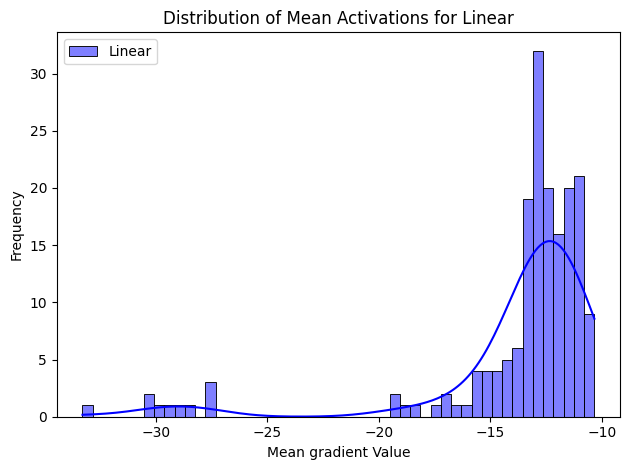

/Users/abnerteng/git/repviz/notebooks/../repviz/tools.py:43: RuntimeWarning: invalid value encountered in scalar divide
  return scaled_hsic / (normalization_x * normalization_y)


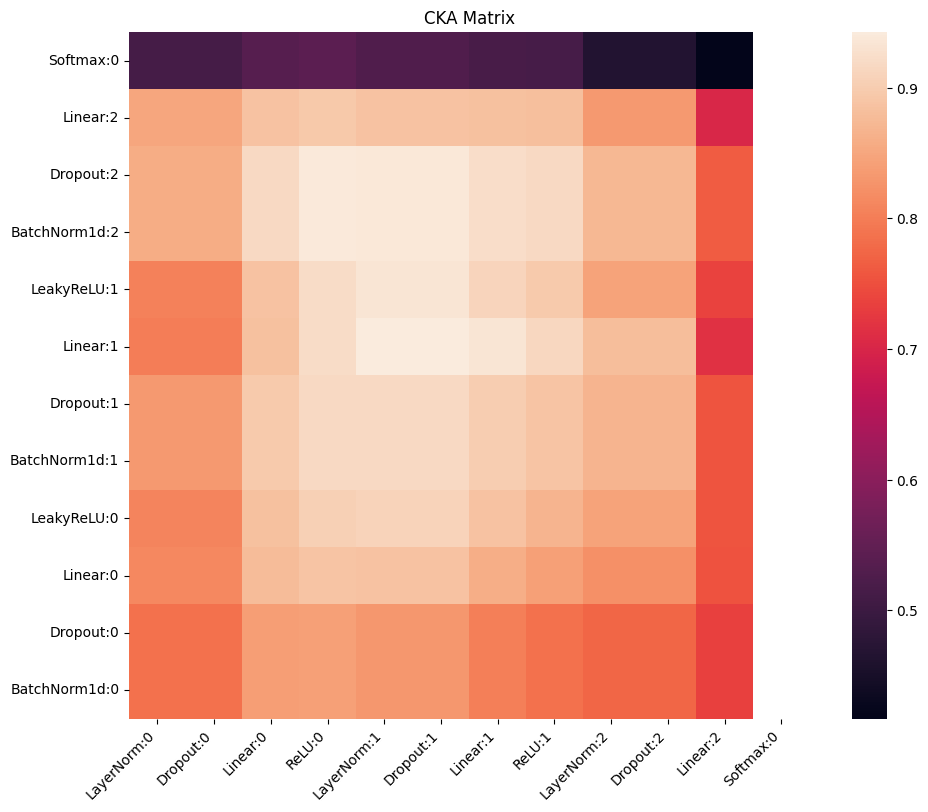

In [7]:
activation_scatter(
    results["FFN"]["activations"]["Linear:1"],
    results["FFN"]["activations"]["ReLU:1"],
    layer_name="ReLU",
)
histogram(
    results["FFN"]["activations"]["Linear:1"],
    viz_type="activation",
    layer_name="Linear",
    bins=50,
)
histogram(
    results["FFN"]["weights"]["Linear:1"],
    viz_type="weight",
    layer_name="Linear",
    bins=50,
)
histogram(
    results["FFN"]["gradients"]["Linear:1"],
    viz_type="gradient",
    layer_name="Linear",
    bins=50,
)
plot_cka(
    results["FFN"]["activations"],
    results["FFN2"]["activations"],
)

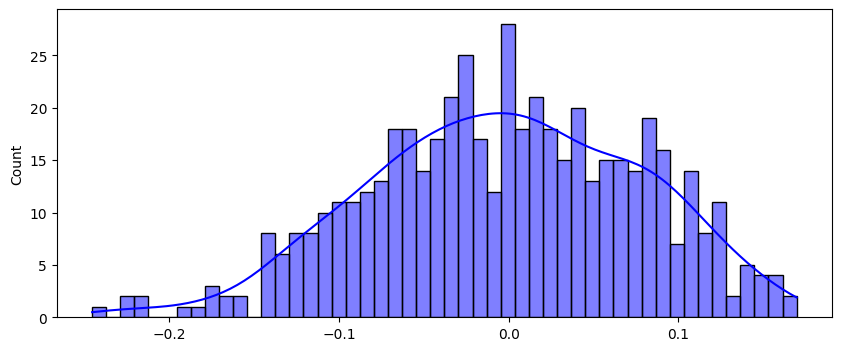

In [8]:
plt.figure(figsize=(10, 4))
sns.histplot(
    results["FFN"]["weights"]["Linear:1"].mean(axis=0).detach().numpy(),
    bins=50,
    kde=True,
    color="blue",
    edgecolor="black",
    label="Linear:1 Mean Weights",
)
plt.show()

/var/folders/5p/5d5cjs1n0sd8dhmpcjd35h0r0000gn/T/ipykernel_37046/131763440.py:1: RuntimeWarning: divide by zero encountered in log
  g = np.log(results["FFN"]["gradients"]["Linear:1"].view(-1).detach().numpy())
/var/folders/5p/5d5cjs1n0sd8dhmpcjd35h0r0000gn/T/ipykernel_37046/131763440.py:1: RuntimeWarning: invalid value encountered in log
  g = np.log(results["FFN"]["gradients"]["Linear:1"].view(-1).detach().numpy())


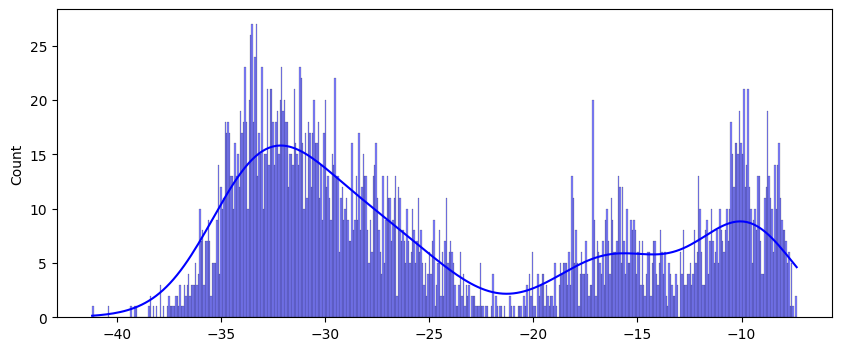

In [9]:
g = np.log(results["FFN"]["gradients"]["Linear:1"].view(-1).detach().numpy())
plt.figure(figsize=(10, 4))
sns.histplot(
    g,
    bins=500,
    kde=True,
    color="blue",
    edgecolor="black",
    label="Linear:1 Mean Weights",
)
plt.show()

Used Activations 1: 12
Used Activations 2: 12


/Users/abnerteng/git/repviz/notebooks/../repviz/tools.py:43: RuntimeWarning: invalid value encountered in scalar divide
  return scaled_hsic / (normalization_x * normalization_y)


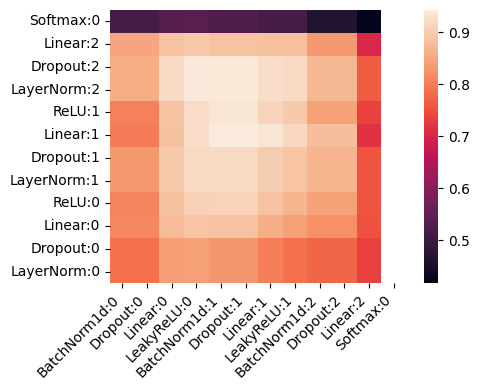

In [10]:
used_activs1 = results["FFN"]["activations"]
used_activs2 = results["FFN2"]["activations"]
print(f"Used Activations 1: {len(used_activs1)}")
print(f"Used Activations 2: {len(used_activs2)}")
cka_matrices = np.empty((len(used_activs1), len(used_activs2)))

for i, (k1, v1) in enumerate(used_activs1.items()):
    for j, (k2, v2) in enumerate(used_activs2.items()):
        cka_value = cka(
            gram_linear(v1.numpy().mean(axis=0)),
            gram_linear(v2.numpy().mean(axis=0)),
        )
        cka_matrices[len(used_activs1) - i - 1, j] = cka_value


plt.figure(figsize=(5, 4))
sns.heatmap(
    cka_matrices,
    annot=False,
    fmt=".2f",
    xticklabels=list(used_activs2.keys()),
    yticklabels=list(used_activs1.keys())[::-1],
)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()